# XGBoost on SQLFlow Tutorial

This is a tutorial on a train/predict XGBoost model in SQLFLow, you can find more SQLFlow usage from the [User Guide](https://github.com/sql-machine-learning/sqlflow/blob/develop/doc/user_guide.md). In this tutorial, we will introduce the following:
- Train an XGBoost model to fit the cars dataset.
- predict the price of a car using a well-trained model.
- Use the [SHAP EXPLAINER](https://github.com/slundberg/shap) tool to interpret the output of the trained model to known how these features affect the price.


## The Dataset

This tutorial would use the [Car Features and MSRP](https://www.kaggle.com/CooperUnion/cardataset) as the demonstration dataset from kaggle.

We have used feature engineering to preprocess the raw data and create new features. The feature engineering file is `carprice_preprocessing.py` in the current directory. Finally, We separated the dataset into the train/test dataset and got the `trainSet.csv` and `testSet.csv` files, which is used to train/predict our model. 

The dataset after preprocessed contains eighty-two features and one label. The features identify the characteristics of a car. Each feature is stored as a single float number. The label `msrp` indicates the car's price. 

The meaning of parts of columns in `trainSet.csv` and `testSet.csv` is shown as follows:

Column | Explain 
-- | -- 
make_* |One-hot value for the "Make" field in the raw data.
engine_fuel_type_* | One-hot value for the "Engine Fuel Type" field in the raw data.
transmission_type_* | One-hot value for the "Transmission Type" field in the raw data.
Driven_Wheels_* | One-hot value for the "Driven_Wheels" field in the raw data.
Vehicle Size_* | One-hot value for the "Vehicle Size" field in the raw data.
Vehicle style_* | One-hot value for the "Vehicle Style" field in the raw data.
market_category_nums | The number of categories for the "Market Category" field in the raw data
category_* |Identify this category in the "Market Category" field of the raw data(1 Yes, 0 No).

We have prepared the cars dataset `trainSet.csv` and `testSet.csv` into SQL table `carprice.train` and `carprice.test` separately. We will be using them as training data and test data respectively.


`Note:`
SQLFlow would automatically split the training dataset into a train/validation dataset while training progress.

We can have a quick peek of the data by running the following standard SQL statements.

In [3]:
%%sqlflow
describe carprice.train;

+-----------------------------------------------+---------+------+-----+---------+-------+
|                     Field                     |   Type  | Null | Key | Default | Extra |
+-----------------------------------------------+---------+------+-----+---------+-------+
|                   engine_hp                   |  float  | YES  |     |   None  |       |
|                engine_cylinders               |  float  | YES  |     |   None  |       |
|                number_of_doors                |  float  | YES  |     |   None  |       |
|                  highway_mpg                  |  float  | YES  |     |   None  |       |
|                    city_mpg                   |  float  | YES  |     |   None  |       |
|                   popularity                  |  float  | YES  |     |   None  |       |
|              market_category_nums             |  float  | YES  |     |   None  |       |
|             category_factory_tuner            |  float  | YES  |     |   None  |       |

In [4]:
%%sqlflow
select *
from carprice.train
limit 1

+-----------+------------------+-----------------+-------------+-----------+------------+----------------------+------------------------+-----------------+---------------------------+----------------------+--------------------+--------------------+-----------------+-----------------+-----------------+--------------------+-----------+----------+------------+---------------+----------------+---------------+------------+-----------+-----------+----------+--------------+-------------+------------+--------------+---------------+----------+-----------------+------------+--------------+------------+------------+--------------------+-----------------+-------------+-----------------+---------------+--------------+--------------+-----------+------------+-------------+-------------+-------------+-----------------+------------+---------------------------+----------------------------+-----------------------------------------------+--------------------------------------------+-----------------------

# Train: Fit Cars Dataset
Let's train an xgboost model on the dataset. We prefer to train the model for `300 rounds`,
and using `squarederror` loss function that the SQLFLow extended SQL can be like:
``` sql
TRAIN xgboost.gbtree
WITH
    train.num_boost_round=300,
    objective="reg:squarederror"
```

`xgboost.gbtree` is the estimator name, `gbtree` is one of the XGBoost booster, you can find more information from [here](https://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters).


To specify the training data, we use standard SQL statements to fetch the traning data from table `carprice.train`:

``` sql
SELECT * FROM carprice.train
```

We can explicit specify which column is used for features in `COLUMN clause` and which column is used for the label by `LABEL` keyword:

``` sql
COLUMN engine_hp, engine_cylinders, number_of_doors, highway_mpg, city_mpg, popularity, market_category_nums, category_factory_tuner, category_luxury, category_high_performance, category_performance, category_flex_fuel, category_hatchback, category_hybrid, category_diesel, category_exotic, category_crossover, make_audi, make_bmw, make_buick, make_cadillac, make_chevrolet, make_chrysler, make_dodge, make_fiat, make_ford, make_gmc, make_genesis, make_hummer, make_honda, make_hyundai, make_infiniti, make_kia, make_land_rover, make_lexus, make_lincoln, make_lotus, make_mazda, make_mercedes_benz, make_mitsubishi, make_nissan, make_oldsmobile, make_plymouth, make_pontiac, make_porsche, make_saab, make_scion, make_subaru, make_suzuki, make_toyota, make_volkswagen, make_volvo, engine_fuel_type_electric, engine_fuel_type_flex_fuel, engine_fuel_type_premium_unleaded_recommended, engine_fuel_type_premium_unleaded_required, engine_fuel_type_regular_unleaded, transmission_type_automatic, transmission_type_direct_drive, transmission_type_manual, transmission_type_unknown, driven_wheels_four_wheel_drive, driven_wheels_front_wheel_drive, driven_wheels_rear_wheel_drive, vehicle_size_large, vehicle_size_midsize, vehicle_style_2dr_suv, vehicle_style_4dr_hatchback, vehicle_style_4dr_suv, vehicle_style_cargo_minivan, vehicle_style_cargo_van, vehicle_style_convertible, vehicle_style_convertible_suv, vehicle_style_coupe, vehicle_style_crew_cab_pickup, vehicle_style_extended_cab_pickup, vehicle_style_passenger_minivan, vehicle_style_passenger_van, vehicle_style_regular_cab_pickup, vehicle_style_sedan, vehicle_style_wagon
LABEL msrp
```

To save the trained model, we can use `INTO clause` to specify a model name:

``` sql
INTO sqlflow_models.my_xgb_regression_model
```

Finally, the following is the SQLFlow Train statment of this regression task, you can run it in the cell:

In [5]:
%%sqlflow
SELECT *
FROM carprice.train
TRAIN xgboost.gbtree
WITH
    objective="reg:squarederror",
    train.num_boost_round = 300,
    eta = 0.1
COLUMN engine_hp, engine_cylinders, number_of_doors, highway_mpg, city_mpg, popularity, market_category_nums, category_factory_tuner, category_luxury, category_high_performance, category_performance, category_flex_fuel, category_hatchback, category_hybrid, category_diesel, category_exotic, category_crossover, make_audi, make_bmw, make_buick, make_cadillac, make_chevrolet, make_chrysler, make_dodge, make_fiat, make_ford, make_gmc, make_genesis, make_hummer, make_honda, make_hyundai, make_infiniti, make_kia, make_land_rover, make_lexus, make_lincoln, make_lotus, make_mazda, make_mercedes_benz, make_mitsubishi, make_nissan, make_oldsmobile, make_plymouth, make_pontiac, make_porsche, make_saab, make_scion, make_subaru, make_suzuki, make_toyota, make_volkswagen, make_volvo, engine_fuel_type_electric, engine_fuel_type_flex_fuel, engine_fuel_type_premium_unleaded_recommended, engine_fuel_type_premium_unleaded_required, engine_fuel_type_regular_unleaded, transmission_type_automatic, transmission_type_direct_drive, transmission_type_manual, transmission_type_unknown, driven_wheels_four_wheel_drive, driven_wheels_front_wheel_drive, driven_wheels_rear_wheel_drive, vehicle_size_large, vehicle_size_midsize, vehicle_style_2dr_suv, vehicle_style_4dr_hatchback, vehicle_style_4dr_suv, vehicle_style_cargo_minivan, vehicle_style_cargo_van, vehicle_style_convertible, vehicle_style_convertible_suv, vehicle_style_coupe, vehicle_style_crew_cab_pickup, vehicle_style_extended_cab_pickup, vehicle_style_passenger_minivan, vehicle_style_passenger_van, vehicle_style_regular_cab_pickup, vehicle_style_sedan, vehicle_style_wagon
LABEL msrp
INTO sqlflow_models.my_xgb_regression_model;

[05:37:19] 5526x81 matrix with 447606 entries loaded from train.txt

[05:37:20] 1412x81 matrix with 114372 entries loaded from test.txt

[0]	train-rmse:1.02225	validation-rmse:1.01601

[1]	train-rmse:0.941115	validation-rmse:0.935793

[2]	train-rmse:0.870557	validation-rmse:0.867713

[3]	train-rmse:0.807627	validation-rmse:0.806864

[4]	train-rmse:0.750709	validation-rmse:0.752408

[5]	train-rmse:0.700593	validation-rmse:0.703485

[6]	train-rmse:0.655812	validation-rmse:0.660677

[7]	train-rmse:0.617791	validation-rmse:0.623334

[8]	train-rmse:0.580582	validation-rmse:0.58753

[9]	train-rmse:0.548645	validation-rmse:0.557749

[10]	train-rmse:0.520323	validation-rmse:0.531564

[11]	train-rmse:0.493716	validation-rmse:0.505629

[12]	train-rmse:0.471069	validation-rmse:0.483921

[13]	train-rmse:0.452157	validation-rmse:0.465113

[14]	train-rmse:0.43495	validation-rmse:0.448872

[15]	train-rmse:0.419212	validation-rmse:0.434243

[16]	train-rmse:0.405707	validation-rmse:0.422638

[17]	train

# Predict the car's price
After training the regression model, let's predict the car price using the trained model.

First, we can specify the trained model by USING clause:

```sql
USING sqlflow_models.my_xgb_regression_model
```

Than, we can specify the prediction result table by PREDICT clause:

```sql
PREDICT carprice.predict.msrp
```

And using a standar SQL to fetch the prediction data:

```sql
SELECT * FROM carprice.test
```

Finally, the following is the SQLFLow Prediction statement:

In [7]:
%%sqlflow
SELECT * FROM carprice.test
PREDICT carprice.predict.msrp
USING sqlflow_models.my_xgb_regression_model;

[05:40:59] 2974x81 matrix with 240894 entries loaded from predict.txt

Done predicting. Predict table : carprice.predict



Let's have a glance at prediction results.

In [10]:
%%sqlflow
SELECT * FROM carprice.predict limit 5;

+-----------+------------------+-----------------+-------------+-----------+------------+----------------------+------------------------+-----------------+---------------------------+----------------------+--------------------+--------------------+-----------------+-----------------+-----------------+--------------------+-----------+----------+------------+---------------+----------------+---------------+------------+-----------+-----------+----------+--------------+-------------+------------+--------------+---------------+----------+-----------------+------------+--------------+------------+------------+--------------------+-----------------+-------------+-----------------+---------------+--------------+--------------+-----------+------------+-------------+-------------+-------------+-----------------+------------+---------------------------+----------------------------+-----------------------------------------------+--------------------------------------------+-----------------------

## Interpret the output of the trained model

We use the analyzer to explain the trained model. The analyzer is implemented based on SHAP.
The ANALYZE SQL will be translated to the SHAP code and SQLFlow enables the code to read the dataset and load the trained model, then draws a figure to explain the model. At this stage, SQLFlow supports using the [TreeExplianer](https://github.com/slundberg/shap#tree-ensemble-example-with-treeexplainer-xgboostlightgbmcatboostscikit-learn-models) to draw a summary plot.

We can set the parameters of shap in WITH part like:

```sql
WITH
    shap_summary.plot_type="dot",
    shap_summary.alpha=1,
    shap_summary.sort=True,
    shap_summary.max_display=20
```
We can plot the SHAP values of every feature for every sample.


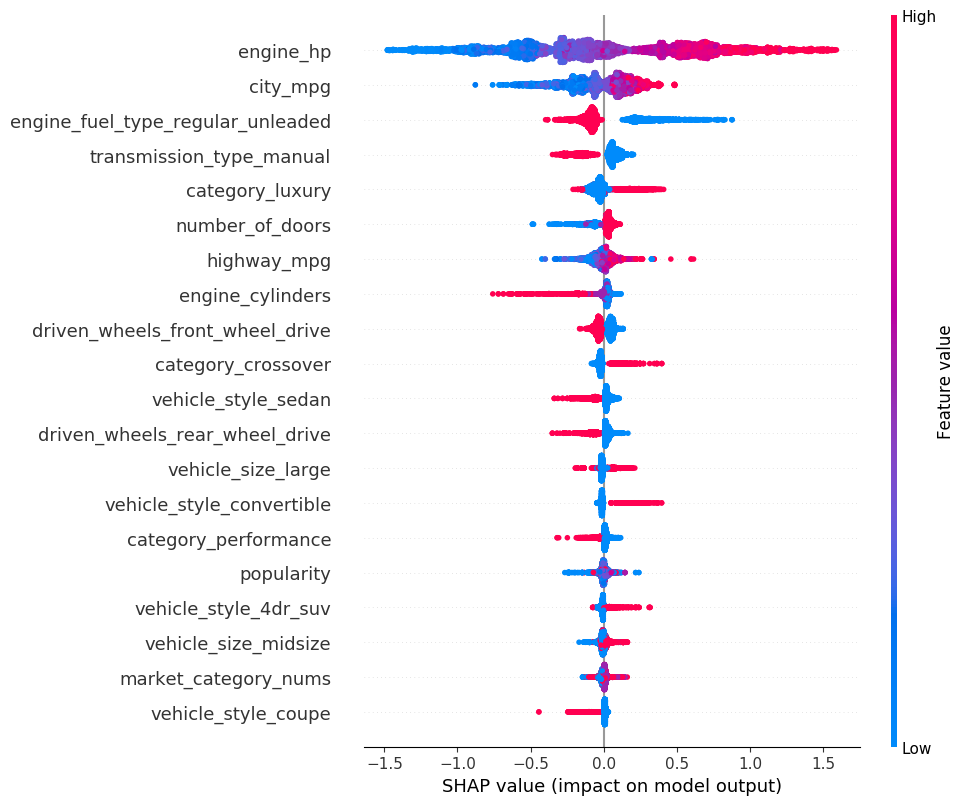

In [13]:
%%sqlflow
SELECT *
FROM carprice.train
ANALYZE sqlflow_models.my_xgb_regression_model
WITH
    shap_summary.plot_type="dot",
    shap_summary.alpha=1,
    shap_summary.sort=True,
    shap_summary.max_display=20
USING TreeExplainer;

The plot above sorts features by the sum of SHAP value magnitudes over all samples, and use SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature values(red high, blue low). This reveals for example that a low engine_hp lowers the predicted car price.

We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot:


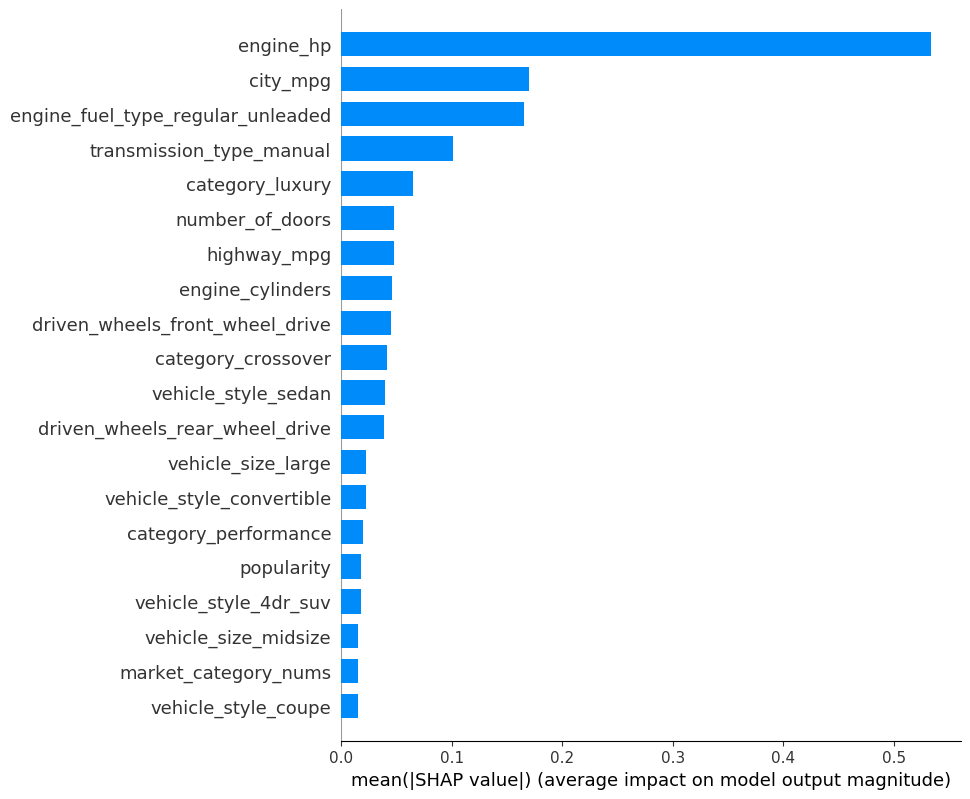

In [14]:
%%sqlflow
SELECT *
FROM carprice.train
ANALYZE sqlflow_models.my_xgb_regression_model
WITH
    shap_summary.plot_type="bar",
    shap_summary.alpha=1,
    shap_summary.sort=True,
    shap_summary.max_display=20
USING TreeExplainer;